### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Set Stock Names

In [2]:
stock_name_1 = 'Microsoft' 
stock_name_2 = 'NovoCurve'

### Load data set

In [3]:
data_stock_1 = pd.read_csv('Microsoft.csv')
data_stock_2 = pd.read_csv('NovoCurve.csv')

###  Ensure Date Column is in Datetime Format

In [4]:
data_stock_1['Date'] = pd.to_datetime(data_stock_1['Date'])
data_stock_2['Date'] = pd.to_datetime(data_stock_2['Date'])

### Calculate Daily Returns

In [5]:
data_stock_1['Return'] = data_stock_1['Adj Close'].pct_change().dropna()
data_stock_2['Return'] = data_stock_2['Adj Close'].pct_change().dropna()

### Drop rows with NaN values resulting from pct_change calculation

In [6]:
data_stock_1 = data_stock_1.dropna(subset=['Return'])
data_stock_2 = data_stock_2.dropna(subset=['Return'])

### Define the exponential decay function

In [7]:
def exp_decay(t, b):
    return np.exp(-b * t)

### Calculate a_k for stock 1

In [8]:
a_k_stock_1 = data_stock_1['Return'].std()

### Calculate rolling standard deviation (volatility) with a window size of 10 days

In [9]:
rolling_volatility_stock_1 = data_stock_1['Return'].rolling(window=10).std().dropna()
time_points_stock_1 = np.arange(len(rolling_volatility_stock_1))

### Fit the exponential decay model to the rolling volatility

In [10]:
popt_stock_1, _ = curve_fit(exp_decay, time_points_stock_1, rolling_volatility_stock_1)
b_stock_1 = popt_stock_1[0]

In [11]:
print(f"Estimated a_k for {stock_name_1}: {a_k_stock_1}")
print(f"Estimated b for {stock_name_1}: {b_stock_1}")

Estimated a_k for Microsoft: 0.0158243429888072
Estimated b for Microsoft: 3.991908672548363


### Calculate a_k for stock 2

In [12]:
a_k_stock_2 = data_stock_2['Return'].std()

### Calculate rolling standard deviation (volatility) with a window size of 10 days

In [13]:
rolling_volatility_stock_2 = data_stock_2['Return'].rolling(window=10).std().dropna()
time_points_stock_2 = np.arange(len(rolling_volatility_stock_2))

### Fit the exponential decay model to the rolling volatility

In [14]:
popt_stock_2, _ = curve_fit(exp_decay, time_points_stock_2, rolling_volatility_stock_2)
b_stock_2 = popt_stock_2[0]

In [15]:
print(f"Estimated a_k for {stock_name_2}: {a_k_stock_2}")
print(f"Estimated b for {stock_name_2}: {b_stock_2}")

Estimated a_k for NovoCurve: 0.06672624944745678
Estimated b for NovoCurve: 1.415778470165602


### Define the utility function

In [16]:
def utility_function(t, a_k, b):
    return 1 - a_k * np.exp(-b * t)

### Assuming we have N days in the dataset

In [17]:
time_points_full_stock_1 = np.arange(len(data_stock_1))
time_points_full_stock_2 = np.arange(len(data_stock_2))

### Calculate utility values for each dataset

In [18]:
utilities_stock_1 = utility_function(time_points_full_stock_1, a_k_stock_1, b_stock_1)
utilities_stock_2 = utility_function(time_points_full_stock_2, a_k_stock_2, b_stock_2)

### Add utility values to the DataFrames for further analysis

In [19]:
data_stock_1['Utility'] = utilities_stock_1
data_stock_2['Utility'] = utilities_stock_2

### Display the first few rows to confirm the utility calculation

In [20]:
print(data_stock_1.head())
print(data_stock_2.head())

        Date        Open        High         Low       Close   Adj Close  \
1 2023-01-04  232.279999  232.869995  225.960007  229.100006  225.852112   
2 2023-01-05  227.199997  227.550003  221.759995  222.309998  219.158356   
3 2023-01-06  223.000000  225.759995  219.350006  224.929993  221.741211   
4 2023-01-09  226.449997  231.240005  226.410004  227.119995  223.900162   
5 2023-01-10  227.759995  231.309998  227.330002  228.850006  225.605652   

     Volume    Return   Utility  
1  50623400 -0.043743  0.984176  
2  39585600 -0.029638  0.999708  
3  43613600  0.011785  0.999995  
4  27369800  0.009736  1.000000  
5  27033900  0.007617  1.000000  
        Date        Open        High         Low       Close   Adj Close  \
1 2023-01-04   68.669998   70.699997   68.470001   70.529999   70.529999   
2 2023-01-05  108.160004  120.029999   94.360001  118.809998  118.809998   
3 2023-01-06  114.154999  116.220001  108.002998  109.040001  109.040001   
4 2023-01-09  102.660004  103.69000

### Perform Monte Carlo simulations

In [21]:
# Number of simulations
n_simulations = 1000
prefer_b_count = 0

for _ in range(n_simulations):
    sample_stock_1 = np.random.choice(data_stock_1['Utility'], size=len(data_stock_1), replace=True)
    sample_stock_2 = np.random.choice(data_stock_2['Utility'], size=len(data_stock_2), replace=True)
    
    mean_u_stock_1 = np.mean(sample_stock_1)
    mean_u_stock_2 = np.mean(sample_stock_2)
    
    if mean_u_stock_2 >= mean_u_stock_1:
        prefer_b_count += 1

### Calculate the probability

In [22]:
probability_b_preferred = prefer_b_count / n_simulations

### Categorize the preference

In [23]:
def categorize_preference(prob, stock_name_1, stock_name_2):
    if prob >= 0.80:
        return f"Strong Preference for {stock_name_2}"
    elif 0.60 <= prob < 0.80:
        return f"Preference for {stock_name_2}"
    elif 0.40 <= prob < 0.60:
        return "Indifference"
    elif 0.20 <= prob < 0.40:
        return f"Preference for {stock_name_1}"
    else:
        return f"Strong Preference for {stock_name_1}"

### Get the preference category

In [24]:
category = categorize_preference(probability_b_preferred, stock_name_1, stock_name_2)

print(f"Probability {stock_name_2} is preferred over {stock_name_1}: {probability_b_preferred * 100:.2f}%")
print(f"Preference Category: {category}")

Probability NovoCurve is preferred over Microsoft: 14.20%
Preference Category: Strong Preference for Microsoft


### Adjust time points to match the rolling volatility length

In [25]:
time_points_stock_1 = np.arange(len(rolling_volatility_stock_1))
time_points_stock_2 = np.arange(len(rolling_volatility_stock_2))

### Truncate the utility arrays to match the length of the time points

In [26]:
utilities_stock_1 = utilities_stock_1[:len(time_points_stock_1)]
utilities_stock_2 = utilities_stock_2[:len(time_points_stock_2)]

### Visualization

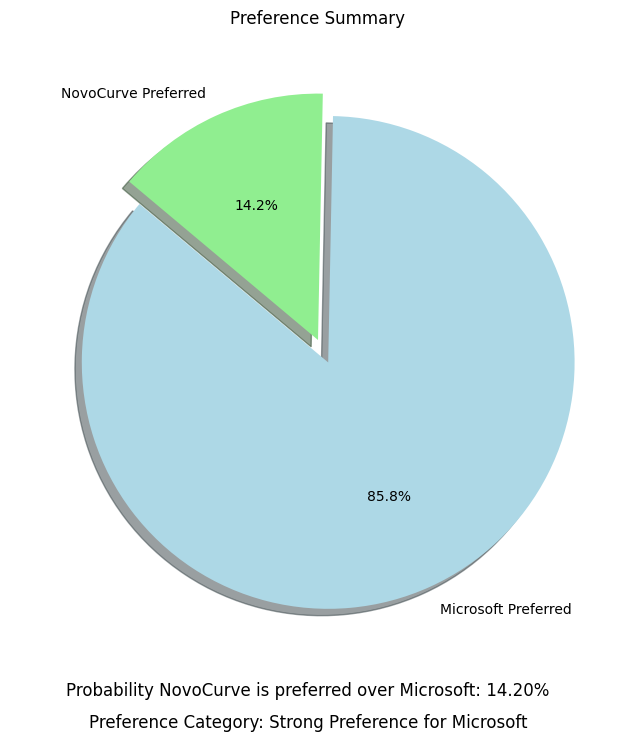

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

# Summary Pie Chart
labels = [f'{stock_name_1} Preferred', f'{stock_name_2} Preferred']
sizes = [n_simulations - prefer_b_count, prefer_b_count]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode first slice
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax.set_title('Preference Summary')

# Add probability and preference category text
probability_text = f"Probability {stock_name_2} is preferred over {stock_name_1}: {probability_b_preferred * 100:.2f}%"
category_text = f"Preference Category: {category}"
plt.gcf().text(0.5, 0.05, probability_text, ha='center', fontsize=12)
plt.gcf().text(0.5, 0.01, category_text, ha='center', fontsize=12)

plt.show()

### Volatility measures the variability of stock returns. It is calculated as the standard deviation of daily returns. High volatility indicates higher risk and potential for larger price swings.

### Rolling Volatility: Volatility measures the variability of stock returns. It is calculated as the standard deviation of daily returns. High volatility indicates higher risk and potential for larger price swings

### Exponential Decay: An exponential decay function is used to model the decrease in volatility over time. The parameter b represents the rate of decay.

### Curve Fitting:Curve fitting helps in estimating the parameters of the exponential decay model by fitting it to the rolling volatility data.

### Utility Function:The utility function quantifies the desirability of an investment, taking into account volatility and its decay over time.

### Monte Carlo Simulations:Monte Carlo simulations model uncertainties by generating a large number of random samples. They help estimate the probability of one stock being preferred over another by evaluating the distribution of utility values.